<a href="https://colab.research.google.com/github/mabeers-arco/3DVision/blob/main/Arch_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Network Architecture 4
Changes from Arch 3
*   Additional planarity constraint implemented - if face is [1,2,3] then there are 3 angles of interest, [1,2,3], [2,3,1] and [3,1,2]. So pad [1,2,3] to [1,2,3,1,2] and window along with window size 3 until encounter -1 which is the padded value.
*  Added animated plots
*  Added numerical summary of shape
*  Based on a slightly larger version of LeNet.

Results
*   Much better reconstructions than before. 
*   Neural network written in such a way that the GPU is actually slower. So that's something to look in to. 
*   Need over 100 epochs to limit to the maximum performance of the network, which takes about 20 minutes. 


To Do
* Write conn2conn transformation function
* If results look ok with objects all with center at origin, then create new dataset such that the objects are no longer centered at the origin. Alternatively, consider training on something more interesting than cuboid objects. 


## Initialize Google Drive

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [15]:
import matplotlib
import torch
import torch.nn as nn
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import sys
import collections
import math
import sys
sys.path.append('/content/drive/MyDrive/239 Project ')
from data_functions import *
from itertools import combinations
import time
import datetime

## Load Data 

### Define Object Class and function to read in pickle data

In [16]:
class object_data():
    def __init__(self, label, xyz, xyz_proj, vis_faces, conn, deg, angs, sda, device):
        self.label = label
        self.xyz = torch.tensor(xyz, dtype=torch.float32).to(device).transpose(0,1)
        self.conn = torch.tensor(conn, dtype=torch.float32).unsqueeze(0).to(device) 
        self.deg = torch.tensor(deg, dtype=torch.float32).to(device) 
        self.angs = torch.tensor(angs, dtype=torch.float32).unsqueeze(0).to(device) 
        self.sda = torch.tensor(sda, dtype=torch.float32).unsqueeze(0).to(device) 
        self.xyz_proj = torch.tensor(xyz_proj, dtype=torch.float32).to(device).transpose(0,1)
        self.vis_faces = vis_faces
        self.device = device

    def show(self, projected = False):
        #credit: https://stackoverflow.com/questions/42301481/adding-specific-lines-to-a-plotly-scatter3d-plot
        pairs = get_edge_vert_pairs_from(self.conn)
        if projected:
            X = self.xyz_proj[0]
            Y = self.xyz_proj[1]
            Z = self.xyz_proj[2]
            print("Vertices = \n", self.xyz_proj)
        else:
            X = self.xyz[0]
            Y = self.xyz[1]
            Z = self.xyz[2]
            print("Vertices = \n", self.xyz)

        print("Faces = ", self.vis_faces)

            
        trace1 = go.Scatter3d(
            x=X,
            y=Y,
            z=Z,
            text = [str(i) for i in range(len(X))],
            mode='markers+text',
            name='Vertices'
        )

        x_lines = list()
        y_lines = list()
        z_lines = list()

        #create the coordinate list for the lines
        for p in pairs:
            for i in range(2):
                x_lines.append(X[p[i]])
                y_lines.append(Y[p[i]])
                z_lines.append(Z[p[i]])
            x_lines.append(None)
            y_lines.append(None)
            z_lines.append(None)

        trace2 = go.Scatter3d(
            x=x_lines,
            y=y_lines,
            z=z_lines,
            mode='lines',
            name='Edges'
        )

        fig = go.Figure(data=[trace1, trace2])
        fig.show()

    #     plotly.offline.iplot(fig, filename='simple-3d-scatter')
    #     print(self.xyz.transpose(0,1))
    #     fig = go.Figure(data=go.Scatter3d(x=self.xyz[0], y=self.xyz[1], z=self.xyz[2], mode='markers'))
    #     fig.show()
    
    def show2d(self):
        pairs = get_edge_vert_pairs_from(self.conn)
        lines = []
        for p in pairs:
            x0 = self.xyz_proj[0, p[0]]
            y0 = self.xyz_proj[1, p[0]]
            x1 = self.xyz_proj[0, p[1]]
            y1 = self.xyz_proj[1, p[1]]
            lines.append([(x0,y0), (x1, y1)])

        lc = matplotlib.collections.LineCollection(lines, color = "orange", linewidths=1)
        fig, ax = pylab.subplots(figsize = (8, 4.5))
        ax.add_collection(lc)
        ax.scatter(self.xyz_proj[0,:], self.xyz_proj[1,:])
        matplotlib.pyplot.xlim(0,1)
        matplotlib.pyplot.ylim(0,1)
        plt.show()


def read_in_object_data(fpath, device):
    with open(fpath, 'rb') as f:
        data = pickle.load(f)
        print(len(data)/8)
        object_list = []
        for i in range(len(data)):
            if(i%8 > 0): # why do we take every fifth object? 
                continue
            object_summary = object_data(label = data[i],
                                         xyz = data[i+1],
                                         vis_faces = data[i+2],
                                         xyz_proj = data[i+3],
                                         conn = data[i+4], 
                                         deg = data[i+5], 
                                         angs = data[i+6],
                                         sda = data[i+7], 
                                         device = device)
            object_list.append(object_summary)

    return object_list


def get_angle(p1, p2, p3):
  """
  Given 3 (x,y,z) 3x1 tensors p1, p2, p3, computes angle between p1 - p2 and p3 - p2
  using the dot product cosine rule. 
  """
  e1 = p1 - p2
  e2 = p3 - p2
  x = torch.dot(e1, e2)/(torch.norm(e1) * torch.norm(e2))
  return torch.rad2deg(torch.acos(x))


def show_list_of_objects2d(object_list):
    n = math.ceil(math.sqrt(len(object_list)))
    fig, axs = plt.subplots(n, n, figsize = (14, 9))
    counter = 0
    for i in range(n):
        for j in range(n):
            if counter == len(object_list):
                break
            ob = object_list[counter]
            pairs = get_edge_vert_pairs_from(ob.conn)
            lines = []
            for p in pairs:
                x0 = ob.xyz_proj[0, p[0]]
                y0 = ob.xyz_proj[1, p[0]]
                x1 = ob.xyz_proj[0, p[1]]
                y1 = ob.xyz_proj[1, p[1]]
                lines.append([(x0,y0), (x1, y1)])

            lc = matplotlib.collections.LineCollection(lines, color = "orange", linewidths=1)
            axs[i, j].add_collection(lc)
            axs[i, j].scatter(ob.xyz_proj[0,:], ob.xyz_proj[1,:])
            axs[i, j].set_xlim(-2,2)
            axs[i, j].set_ylim(-2,2)
            counter += 1

### Load Data and Visualize

In [17]:
device = "cpu"
train_path = '/content/drive/MyDrive/239 Project /dataARCO5.pickle'
objects = read_in_object_data(train_path, device=device)

3500.0


In [18]:
k = np.random.choice(len(objects), 1)[0]
print("k = ", k)
objects[k].show(projected=True)

k =  387
Vertices = 
 tensor([[ -0.2332,  -0.2569,   1.3572,   1.1968,   0.5876,   0.5639],
        [  1.0177,  -0.7743,  -0.2723,   0.7948,   1.1053,  -0.6867],
        [-11.0771, -10.7644, -11.4181, -11.3504, -10.5127, -10.2000]])
Faces =  [[2, 3, 4, 5], [0, 1, 5, 4]]


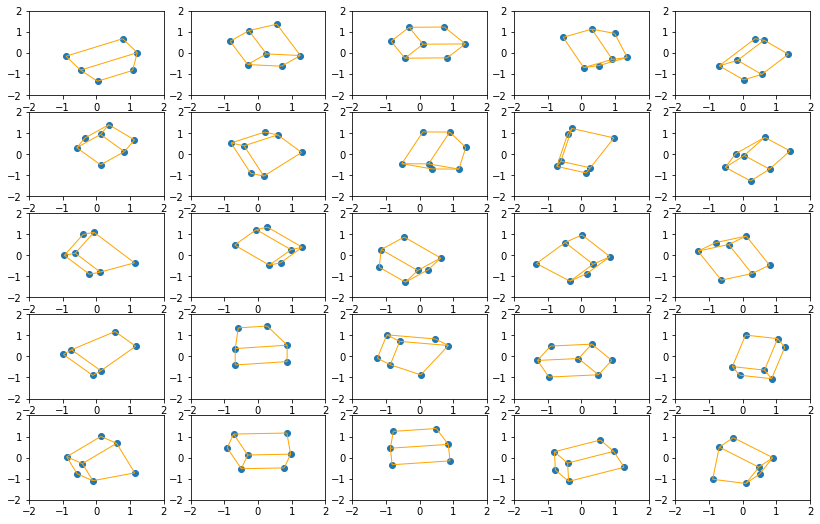

In [19]:
show_list_of_objects2d([objects[k] for k in np.random.choice(len(objects), 5**2)])

### Functions to go from list of objects to network inputs

In [20]:
def get_xyz_Arch2(obj, layer, network_size):
  n = len(obj.xyz_proj[layer])
  pad = network_size - n
  coord_mat = obj.xyz_proj[layer].unsqueeze(0).repeat(n,1) 
  M = nn.ZeroPad2d((0, pad, 0, pad))
  return M(coord_mat)

def get_conn_mat_Arch2(obj, network_size):
  pairs = get_edge_vert_pairs_from(obj.conn)
  n = len(obj.xyz_proj[0])
  pad = network_size - n
  conn_mat = torch.zeros(network_size,network_size)
  for i in range(network_size):
    for j in range(network_size):
      if (i,j) in pairs or (j,i) in pairs:
        conn_mat[i,j] = torch.tensor(1.)
  return conn_mat


def expand(triple, network_size):
  mat = torch.zeros((network_size, 3))
  mat[triple[0], 0] = 1. 
  mat[triple[1], 1] = 1.
  mat[triple[2], 2] = 1.
  return mat

def format_faces(obj, max_face_size, max_faces):
  faces = -1 * torch.ones((max_faces, max_face_size), dtype = torch.int8)
  for i in range(len(obj.vis_faces)):
    N = len(obj.vis_faces[i])
    assert N+2 <= max_face_size, "provided face too large!"
    face = obj.vis_faces[i] + obj.vis_faces[i][:2]
    faces[i, :N+2] = torch.tensor(face, dtype=torch.int8)
  return faces

def get_triples(conn, max_angles):
  triples = []
  pairs = get_edge_vert_pairs_from(conn)
  M = max([max(p) for p in pairs])

  shared = {}
  for shared_index in range(M+1):
      we_share_a_vertex = []
      for pair in pairs:
          if shared_index == pair[0]:
            we_share_a_vertex.append(pair[1])
          elif shared_index == pair[1]:
            we_share_a_vertex.append(pair[0])

      shared[shared_index] = we_share_a_vertex

  for key in shared.keys():
    for ends in combinations(shared[key], 2):
      triples.append([ends[0], key, ends[1]])
      #triples.append(expand([ends[0], key, ends[1]], network_size))
  #print(shared)
  pad = max_angles - len(triples)
  triples2 = torch.cat([torch.tensor(triples), torch.zeros(pad,3)], dim = 0)
  return triples2
  

def get_sda(obj, max_angles):
  x = get_triples(obj.conn, max_angles).int().tolist()
  batch_angles = []
  i = 0
  while x[i] != [0,0,0]:
    #print("verts = ", x[i])
    v1 = obj.xyz[:, x[i][0]]
    v2 = obj.xyz[:, x[i][1]]
    v3 = obj.xyz[:, x[i][2]]
    A = get_angle(v1,v2,v3)
    #print("Angle = ", A)
    batch_angles.append(A)
    i += 1
  return torch.std(torch.stack(batch_angles))


def get_data_set_Arch_4(object_list, network_size, max_angles, train_test_sizes = None):
  n = len(object_list)
  if not train_test_sizes:
    train_size = math.ceil(n*0.8)
    inds = np.random.choice(range(n), n, replace = False)
    train_inds = inds[:train_size]
    test_inds = inds[train_size:]
    train_objects = [object_list[k] for k in range(n) if k in train_inds]
    test_objects = [object_list[k] for k in range(n) if k in test_inds]
  else:
    inds = np.random.choice(range(n), sum(train_test_sizes), replace = False)
    train_inds = inds[:train_test_sizes[0]]
    test_inds = inds[train_test_sizes[0]:]
    train_objects = [object_list[k] for k in range(n) if k in train_inds]
    test_objects = [object_list[k] for k in range(n) if k in test_inds]


  train_dataset = torch.utils.data.TensorDataset(torch.stack([get_xyz_Arch2(obj, 0, network_size) for obj in train_objects]), #X
                                                 torch.stack([get_xyz_Arch2(obj, 1, network_size) for obj in train_objects]), #Y
                                                 torch.stack([get_xyz_Arch2(obj, 2, network_size) for obj in train_objects]), #Z
                                                 torch.stack([get_conn_mat_Arch2(obj, network_size) for obj in train_objects]), #conn
                                                 torch.tensor([obj.label for obj in train_objects]), # label
                                                 torch.tensor([get_sda(obj , max_angles) for obj in train_objects]), #sda
                                                 torch.tensor([number_of_visible_verts(obj) for obj in train_objects]), #num_vv
                                                 torch.stack([get_triples(obj.conn, max_angles) for obj in train_objects]),
                                                 torch.stack([format_faces(obj, 8,8) for obj in train_objects])) #triples

  test_dataset = torch.utils.data.TensorDataset(torch.stack([get_xyz_Arch2(obj, 0, network_size) for obj in test_objects]), #X
                                                torch.stack([get_xyz_Arch2(obj, 1, network_size) for obj in test_objects]), #Y
                                                torch.stack([get_xyz_Arch2(obj, 2, network_size) for obj in test_objects]), #Z
                                                torch.stack([get_conn_mat_Arch2(obj, network_size) for obj in test_objects]), #conn
                                                torch.tensor([obj.label for obj in test_objects]), # label
                                                torch.tensor([get_sda(obj , max_angles) for obj in test_objects]), #sda
                                                torch.tensor([number_of_visible_verts(obj) for obj in test_objects]), #num_vv
                                                torch.stack([get_triples(obj.conn, max_angles) for obj in test_objects]),
                                                torch.stack([format_faces(obj, 8,8) for obj in test_objects])) #filter_mat


  return train_dataset, test_dataset


### Test Above Functions

In [21]:
#tts = (1000, 100)
tts = (30, 4)
train_data, test_data = get_data_set_Arch_4(objects, network_size = 20, max_angles = 50, train_test_sizes=tts)

In [22]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=5, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

In [23]:
batch = next(iter(train_loader))
for b in batch:
  print(b.shape)


torch.Size([5, 20, 20])
torch.Size([5, 20, 20])
torch.Size([5, 20, 20])
torch.Size([5, 20, 20])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5, 50, 3])
torch.Size([5, 8, 8])


In [24]:
print(objects[4].vis_faces)
ff = format_faces(objects[4], 8, 8)
ff

[[0, 3, 2, 1], [1, 2, 6, 5], [0, 1, 5, 4]]


tensor([[ 0,  3,  2,  1,  0,  3, -1, -1],
        [ 1,  2,  6,  5,  1,  2, -1, -1],
        [ 0,  1,  5,  4,  0,  1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int8)

In [25]:
x = get_triples(objects[k].conn, 20).int().tolist()
batch_angles = []
i = 0
while x[i] != [0,0,0]:
  v1 = objects[k].xyz[:, x[i][0]]
  v2 = objects[k].xyz[:, x[i][1]]
  v3 = objects[k].xyz[:, x[i][2]]
  A = get_angle(v1,v2,v3)
  #print(x[i], A)
  batch_angles.append(A)
  i += 1

torch.std(torch.stack(batch_angles))

tensor(12.1967)

### Plotting Functions

In [26]:
def pairs_from_conn(conn):
  conn = conn.squeeze()
  pairs = []
  h, w = conn.shape
  for i in range(h):
    for j in range(w):
      if conn[i,j] == True and (j, i) not in pairs:
        pairs.append((i, j))
  return pairs


def show3D(xyz, conn, am = "data"):
  #credit: https://stackoverflow.com/questions/42301481/adding-specific-lines-to-a-plotly-scatter3d-plot
  pairs = pairs_from_conn(conn)
  xyz = xyz.detach().numpy()

  trace1 = go.Scatter3d(
      x=xyz[0],
      y=xyz[1],
      z=xyz[2],
      text = [str(i) for i in range(len(xyz[0]))],
      mode='markers+text',
      name='Vertices'
  )


  #create the coordinate list for the lines
  x_lines = []
  y_lines = []
  z_lines = []
  for p in pairs:
      for i in range(2):
          x_lines.append(xyz[0][p[i]])
          y_lines.append(xyz[1][p[i]])
          z_lines.append(xyz[2][p[i]])
      x_lines.append(None)
      y_lines.append(None)
      z_lines.append(None)

  trace2 = go.Scatter3d(
      x=x_lines,
      y=y_lines,
      z=z_lines,
      mode='lines',
      name='Edges'
  )
  layout = go.Layout(width=600, height=600, 
                     scene=dict(aspectmode=am, aspectratio=dict(x=1, y=1, z=1)))

  fig = go.Figure(data=[trace1, trace2], layout=layout)

  fig.show()

In [27]:
threes = get_triples(objects[3].conn, 20)
threes.int().tolist()

[[1, 0, 3],
 [0, 1, 2],
 [0, 1, 4],
 [2, 1, 4],
 [1, 2, 3],
 [1, 2, 5],
 [3, 2, 5],
 [2, 3, 0],
 [2, 3, 6],
 [0, 3, 6],
 [5, 4, 1],
 [4, 5, 6],
 [4, 5, 2],
 [6, 5, 2],
 [5, 6, 3],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0]]

## Define Architecture 4A

In [28]:
class Arch4A(nn.Module):    
    def __init__(self, vertices, nonlinearity = torch.tanh, device = "cpu"):
        super(Arch4A, self).__init__()

        self.vertices = vertices
        self.nonlinearity = nonlinearity
        self.device = device

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = torch.nn.Conv2d(16, 32, 3, 1, padding = 1)
        self.pool2 = nn.MaxPool2d(2, stride = 2)
        self.fc0 = nn.Linear(2 * vertices * vertices, vertices*vertices) # [32*20/4*20/4] = [32/16*20*20]
        self.fc1 = nn.Linear(self.vertices*self.vertices, self.vertices)
        self.fc2 = nn.Linear(self.vertices, self.vertices)
                        
    def get_angle(self, p1, p2, p3):
      e1 = p1 - p2
      e2 = p3 - p2
      x = torch.dot(e1, e2)/(torch.norm(e1) * torch.norm(e2))
      return torch.rad2deg(torch.acos(x))
    
    def forward_1(self, x, y, conn):
        batch_size = x.shape[0]
        #suppose batch size = 10 and network size = 20, all shapes after assignment
        z = self.conv1(torch.stack([x,y,conn], dim = 1)) #[10, 16, 20, 20]
        z = self.pool2(z) #[10, 16, 10, 10]
        z = self.nonlinearity(z)
        z = self.conv2(z) #[10, 32, 10, 10]
        z = self.pool2(z) #[10, 32, 5, 5]
        z = self.nonlinearity(z)
        z = z.view(batch_size, -1) #[10, 32 * 5 * 5]
        z = self.fc0(z)
        z = self.nonlinearity(z)
        z = self.fc1(z)
        zeroz = torch.zeros(batch_size, self.vertices).to(self.device)
        new_xyz = torch.stack([x[:,0],y[:,0],zeroz], dim = 2).permute(0,2,1)
        new_xyz[:,2,:] = z 
        return new_xyz


    def forward(self, x, y, conn, num_vv, triples, faces, extract_xyz = False):
        batch_size = x.shape[0]
        # Pick XYZ estimates
        new_xyz = self.forward_1(x,y,conn)

        # compute angles by selecting 3 points 
        stop = torch.zeros(3).to(self.device)
        max_angles = triples.shape[1]
        sda = torch.zeros(batch_size, requires_grad=False).to(self.device)
        planarity = torch.zeros(batch_size).to(self.device)
        angles = []
        for b in range(batch_size):
          i = 0
          #batch_angles = torch.zeros(max_angles, requires_grad=False)
          batch_angles = {}
          while not all(triples[b, i, :] == stop):
            t = triples[b, i, :].int()
            v1 = new_xyz[b, :, t[0]]
            v2 = new_xyz[b, :, t[1]]
            v3 = new_xyz[b, :, t[2]]
            batch_angles[str(t.tolist())] = self.get_angle(v1, v2, v3)
            i += 1
          angles.append(batch_angles)
          sda[b] = torch.std(torch.stack([*batch_angles.values()]))
          #print("batch ", b, " batch angles = ", batch_angles)
        
          # Planarity constraint
          #print(faces.shape)
          p = 0
          for i in range(faces.shape[1]):              
            for j in range(faces.shape[2]):
              key1 = faces[b, i, j:j+3].tolist()
              if -1 in key1 and j > 0:
                p = p - 180*(j-2) 
                # print("i,j = ",i,j)
                # print("180*j is", 180*(j-2))
                break
              elif j == 0 and -1 in key1:
                break
              key1s = str(key1)
              try: 
                #print(key1s, batch_angles[key1s])
                p = p + batch_angles[key1s]
                #print("key1 worked! p = {}, i = {}, j = {}, b = {}, add angle = {}".format(p, i,j,b, batch_angles[key1s]))
              except KeyError:
                key2 = key1.copy()
                key2.reverse()
                key2s = str(key2)
                #print(key2s, batch_angles[key2s])
                p = p + batch_angles[key2s]
                #print("key2 worked! p = {}, i = {}, j = {}, b = {}, add angle = {}".format(p, i,j,b, batch_angles[key2s]))
            p = abs(p)
            #print("face {} p = {}".format(i, p))

          planarity[b] = abs(p)

        gamma = 1.
        loss = sda + gamma*planarity  
            
        #print("planarity = ", planarity)
        if extract_xyz: 
          return new_xyz, sda, planarity, loss, angles 

        return loss

## Define Architecture 4B

In [29]:
class Arch4B(nn.Module):    
    def __init__(self, vertices, nonlinearity = torch.tanh, device = "cpu"):
        super(Arch4B, self).__init__()

        self.vertices = vertices
        self.nonlinearity = nonlinearity
        self.device = device

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1, padding = 1)
        self.pool2 = nn.MaxPool2d(2, stride = 2)
        self.fc0 = nn.Linear(4 * vertices * vertices, 2 * vertices*vertices) # [64*20/4*20/4] = [64/16*20*20]
        self.fc1 = nn.Linear(2 * self.vertices*self.vertices, self.vertices*self.vertices)
        self.fc2 = nn.Linear(self.vertices*self.vertices, self.vertices)
                        
    def get_angle(self, p1, p2, p3):
      e1 = p1 - p2
      e2 = p3 - p2
      x = torch.dot(e1, e2)/(torch.norm(e1) * torch.norm(e2))
      return torch.rad2deg(torch.acos(x))
    
    def forward_1(self, x, y, conn):
        batch_size = x.shape[0]
        #suppose batch size = 10 and network size = 20, all shapes after assignment
        z = self.conv1(torch.stack([x,y,conn], dim = 1)) #[10, 16, 20, 20]
        z = self.pool2(z) #[10, 16, 10, 10]
        z = self.nonlinearity(z)
        z = self.conv2(z) #[10, 32, 10, 10]
        z = self.pool2(z) #[10, 32, 5, 5]
        z = self.nonlinearity(z)
        z = z.view(batch_size, -1) #[10, 32 * 5 * 5]
        z = self.fc0(z)
        z = self.nonlinearity(z)
        z = self.fc1(z)
        z = self.nonlinearity(z)
        z = self.fc2(z)
        zeroz = torch.zeros(batch_size, self.vertices).to(self.device)
        new_xyz = torch.stack([x[:,0],y[:,0],zeroz], dim = 2).permute(0,2,1)
        new_xyz[:,2,:] = z 
        return new_xyz


    def forward(self, x, y, conn, num_vv, triples, faces, extract_xyz = False):
        batch_size = x.shape[0]
        # Pick XYZ estimates
        new_xyz = self.forward_1(x,y,conn)

        # compute angles by selecting 3 points 
        stop = torch.zeros(3).to(self.device)
        max_angles = triples.shape[1]
        sda = torch.zeros(batch_size, requires_grad=False).to(self.device)
        planarity = torch.zeros(batch_size).to(self.device)
        angles = []
        for b in range(batch_size):
          i = 0
          #batch_angles = torch.zeros(max_angles, requires_grad=False)
          batch_angles = {}
          while not all(triples[b, i, :] == stop):
            t = triples[b, i, :].int()
            v1 = new_xyz[b, :, t[0]]
            v2 = new_xyz[b, :, t[1]]
            v3 = new_xyz[b, :, t[2]]
            batch_angles[str(t.tolist())] = self.get_angle(v1, v2, v3)
            i += 1
          angles.append(batch_angles)
          sda[b] = torch.std(torch.stack([*batch_angles.values()]))
          #print("batch ", b, " batch angles = ", batch_angles)
        
          # Planarity constraint
          #print(faces.shape)
          p = 0
          for i in range(faces.shape[1]):              
            for j in range(faces.shape[2]):
              key1 = faces[b, i, j:j+3].tolist()
              if -1 in key1 and j > 0:
                p = p - 180*(j-2) 
                # print("i,j = ",i,j)
                # print("180*j is", 180*(j-2))
                break
              elif j == 0 and -1 in key1:
                break
              key1s = str(key1)
              try: 
                #print(key1s, batch_angles[key1s])
                p = p + batch_angles[key1s]
                #print("key1 worked! p = {}, i = {}, j = {}, b = {}, add angle = {}".format(p, i,j,b, batch_angles[key1s]))
              except KeyError:
                key2 = key1.copy()
                key2.reverse()
                key2s = str(key2)
                #print(key2s, batch_angles[key2s])
                p = p + batch_angles[key2s]
                #print("key2 worked! p = {}, i = {}, j = {}, b = {}, add angle = {}".format(p, i,j,b, batch_angles[key2s]))
            p = abs(p)
            #print("face {} p = {}".format(i, p))

          planarity[b] = abs(p)

        gamma = 1.
        loss = sda + gamma*planarity  
            
        #print("planarity = ", planarity)
        if extract_xyz: 
          return new_xyz, sda, planarity, loss, angles 

        return loss

### Troubleshoot network

In [30]:
L1_loss = torch.nn.L1Loss()
net = Arch4A(20, nonlinearity=torch.sigmoid)
x,y,z,conn,label,sda, num_vv, triples, faces = next(iter(train_loader))
sdas = net.forward(x,y,conn, num_vv, triples, faces)
loss = L1_loss(sdas, sda)
loss

tensor(34.6521, grad_fn=<L1LossBackward>)

In [31]:
L1_loss = torch.nn.L1Loss()
net = Arch4B(20, nonlinearity=torch.sigmoid)
x,y,z,conn,label,sda, num_vv, triples, faces = next(iter(train_loader))
sdas = net.forward(x,y,conn, num_vv, triples, faces)
loss = L1_loss(sdas, sda)
loss

tensor(35.2063, grad_fn=<L1LossBackward>)

## Train Network

In [77]:
device = "cpu"

### Define Datasets

In [78]:
train_data, test_data = get_data_set_Arch_4(objects, network_size = 20, max_angles = 50,train_test_sizes=(1000, 100))

In [79]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

### Initialize Network

In [86]:
device = "cpu"
#net = Arch4A(20, nonlinearity=torch.sigmoid, device=device)
#net_cuda = net.to(device)
net = Arch4B(20, nonlinearity=torch.sigmoid, device=device)

### Define Loss And Optimizer

In [87]:
L1_loss = torch.nn.L1Loss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
#opt_cuda = torch.optim.Adam(net_cuda.parameters(), lr=1e-3)

### Define Train Step Function

In [88]:
def train_step(x, y, conn, num_vv, triples, faces, sda, net, opt_fn, loss_fn):
    sda_est = net(x, y, conn, num_vv, triples, faces)
    loss = loss_fn(sda_est, sda)
    loss.backward()
    opt_fn.step()
    opt_fn.zero_grad()
    return loss

### Train Loop
* 5 epochs takes 42 seconds, so about **8 seconds per epoch on CPU** with 1000 objects in each epoch and architecture 4A. 
* 5 epochs takes 91 seconds, so about **18 seconds per epoch on GPU** with 1000 objects in each epoch and architecture 4A. 
* 5 epochs takes 41 seconds, **8 seconds per epoch on CPU** with 1000 objects in each epoch and architecture ***4B***. 
* Loss function seems to limit at at loss of about 1 or 2 degrees after about 100 epochs. 50 epochs takes about 7 minutes so training for 150 epochs to ensure you're doing ok could take 20 minutes or so.  

In [109]:
start_time = time.time()
epochs = 50
loss_hist_train = []
counter = 0
for epoch in range(epochs):
    for x,y,z,conn,label,sda, num_vv, triples, faces in iter(train_loader):   
        loss = train_step(x.to(device), y.to(device), conn.to(device), num_vv.to(device), 
                          triples.to(device), faces.to(device), sda.to(device), net, opt, L1_loss)
        loss_hist_train.append(loss.item())
        counter += 1
        if counter % 50 == 0:
          print(loss.item())
    print("epoch ", epoch)
print("Elapsed Time = ", datetime.timedelta(seconds=round(time.time() - start_time)))

1.273766279220581
1.0701109170913696
epoch  0
1.1198980808258057
1.5879887342453003
epoch  1
1.8921741247177124
3.372269868850708
epoch  2
1.7535572052001953
1.6148147583007812
epoch  3
2.1851718425750732
1.403926134109497
epoch  4
1.2605363130569458
2.1966392993927
epoch  5
1.867725133895874
1.7549362182617188
epoch  6
1.8315048217773438
1.059420108795166
epoch  7
1.693027138710022
0.9039848446846008
epoch  8
1.5755574703216553
1.1346100568771362
epoch  9
1.4688225984573364
1.7745256423950195
epoch  10
0.8637336492538452
1.0135283470153809
epoch  11
1.1791490316390991
0.6481643915176392
epoch  12
1.4770588874816895
1.3213365077972412
epoch  13
1.0495277643203735
0.8100529909133911
epoch  14
2.483381748199463
1.4795678853988647
epoch  15
1.4823250770568848
2.0504989624023438
epoch  16
1.5299241542816162
1.5357654094696045
epoch  17
0.9992491602897644
2.0110363960266113
epoch  18
1.1376324892044067
1.3464583158493042
epoch  19
1.916172742843628
0.9354604482650757
epoch  20
1.64340090751

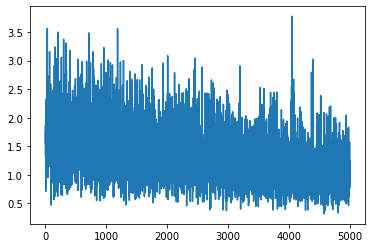

In [110]:
plt.plot(loss_hist_train);

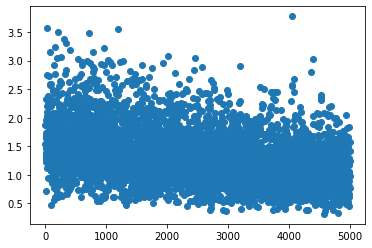

In [111]:
plt.scatter(np.arange(len(loss_hist_train)), loss_hist_train);

##Load Model Instead of Training

In [32]:
device = "cpu"
net_12_14 = Arch4B(20, nonlinearity=torch.sigmoid, device=device)
opt_12_14 = torch.optim.Adam(net_12_14.parameters(), lr=1e-3)

checkpoint = torch.load('/content/drive/MyDrive/239 Project /model_12_14_2020_Arch4B.pickle')
net_12_14.load_state_dict(checkpoint['model_state_dict'])
opt_12_14.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_12_14 = checkpoint['epoch']
loss_12_14 = checkpoint['loss']
print("Epoch = {}, Loss = {}".format(epoch_12_14, loss_12_14))

Epoch = 150, Loss = 0.9795314073562622


## Reconstructions

### Functions for Numerical Summary of Reconstruction

In [147]:
def extract_xyz(x,y,z, num_vv):
  X = x[0, 0, :num_vv]
  Y = y[0, 0, :num_vv]
  Z = z[0, 0, :num_vv]
  return torch.stack([X,Y,Z])

def string_to_list(s):
  """
  Takes string of the form '[1,2,3]' and returns the list [1,2,3]
  """
  l = list(s.replace("[", "").replace("]", "").split(","))
  return [int(x) for x in l]

def get_pairs_from_square_conn(conn):
  conn = conn.squeeze()
  h,w = conn.shape
  pairs = []
  for i in range(h):
    for j in range(i+1, w):
      if conn[i,j] == 1.:
        pairs.append((i,j))
  return pairs


def get_angle(p1, p2, p3):
  """
  Given 3 (x,y,z) 3x1 tensors p1, p2, p3, computes angle between p1 - p2 and p3 - p2
  using the dot product cosine rule. 
  """
  e1 = p1 - p2
  e2 = p3 - p2
  x = torch.dot(e1, e2)/(torch.norm(e1) * torch.norm(e2))
  return torch.rad2deg(torch.acos(x))

def single_object_summary(next_iter_loader, net, return_xyzs=False):
  """
  Inputs: 
  loader = dataloader with sample size 1, probably the test loader
  net = neural network to evaluate loader data on

  Takes a single example from the loader and passes the data through the net, 
  and then provides numerical summaries of the original and reconstructed data.
  """

  x, y, z, conn, label, sda, num_vv, triples, faces = next_iter_loader  
  new_xyz, est_sda, planarity, loss, angles = net(x, y, conn, num_vv, triples, faces, extract_xyz = True)

  # XYZ DataFrame ######################
  xyz_original = extract_xyz(x,y,z, num_vv)
  reconstructed_z = new_xyz.squeeze()[2, :num_vv].detach().numpy()
  xyz_df = pd.DataFrame(xyz_original).astype("float").T
  xyz_df.columns = ['X', 'Y', 'Actual Z']
  xyz_df.insert(3, "Estimated Z", reconstructed_z)


  # Angle DataFrame #####################
  angles = angles[0]
  verts = list(angles.keys())
  angs = [x.detach().squeeze().tolist() for x in angles.values()]
  #print("actual std = ", torch.std(torch.stack(list(angles.values()))))
  angles_df = pd.DataFrame([verts, angs]).T
  angles_df.columns = ['Vertices', 'Estimated Angle']
  angles_df.index = [str(i+1) for i in range(len(verts))]

  # get actual angles
  actual_angles = []
  for vert in verts:
    vert_list = string_to_list(vert)
    v0 = xyz_original[:, vert_list[0]]
    v1 = xyz_original[:, vert_list[1]]
    v2 = xyz_original[:, vert_list[2]]
    #print(vert, get_angle(v0, v1, v2))
    actual_angles.append(get_angle(v0, v1, v2))
  angles_df.insert(1, "Actual Angle", torch.stack(actual_angles).tolist())
  
  # Loss DataFrame #################
  loss_list = [[est_sda.squeeze().detach().tolist(), sda.squeeze().detach().tolist()],
               [planarity.detach().tolist()[0], 0],
               [loss.squeeze().detach().tolist(),sda.squeeze().detach().tolist()]]
  loss_df = pd.DataFrame(loss_list, 
                         columns = ["Estimated", "Actual"], 
                         index=['SDA', 'Deviation from Planarity', 'Total Loss'])

  print("------------------------------------------------------")
  print("ANGLES")
  print(angles_df)
  print("------------------------------------------------------")
  print("SDA + PLANARITY")
  print(loss_df) 
  print("------------------------------------------------------")
  print("XYZ")
  print(xyz_df)
  print("------------------------------------------------------")

  # Faces DataFrame
  faces = faces.squeeze().tolist()
  pad_indexs = [f.index(-1) for f in faces]
  new_faces = []
  for i in range(len(faces)):
    if pad_indexs[i] > 0:
      new_faces += [faces[i][:pad_indexs[i]]]
  
  face_dfs = []
  for f in new_faces:
    print("FACE {}".format(f[:len(f)-2]))
    threes = [f[i:i+3] for i in range(len(f) - 2)]
    actual_angles = []
    reconstructed_angles = []
    for vert in threes:
      v0 = xyz_original[:, vert[0]]
      v1 = xyz_original[:, vert[1]]
      v2 = xyz_original[:, vert[2]]
      actual_angles.append(get_angle(v0, v1, v2))
      v3 = new_xyz.squeeze()[:, vert[0]]
      v4 = new_xyz.squeeze()[:, vert[1]]
      v5 = new_xyz.squeeze()[:, vert[2]]
      reconstructed_angles.append(get_angle(v3, v4, v5))
    face_df = pd.DataFrame([[str(t) for t in threes], 
                            [a.tolist() for a in actual_angles], 
                            [ra.detach().tolist() for ra in reconstructed_angles]]).T
    face_df.columns = ['Vertices', 'Actual Angle','Estimated Angle']
    face_df.loc['Total'] = pd.Series([face_df['Actual Angle'].sum(), face_df['Estimated Angle'].sum()], 
                                     index = ['Actual Angle', 'Estimated Angle'])
    print(face_df)
    print("------------------------------------------------------")

  # Distances DataFrame
  pairs = get_pairs_from_square_conn(conn) 
  actual_distances = []
  estimated_distances = []
  for pair in pairs:
    i0 = pair[0]
    i1 = pair[1]
    d_actual = torch.linalg.norm(xyz_original[:, i0] - xyz_original[:, i1])
    d_estimated = torch.linalg.norm(new_xyz.squeeze()[:, i0] - new_xyz.squeeze()[:, i1])
    actual_distances.append(d_actual)
    estimated_distances.append(d_estimated)
  
  dist_df = pd.DataFrame([[str(pair) for pair in pairs],
                          [a.tolist() for a in actual_distances],
                          [a.tolist() for a in estimated_distances]]).T
  dist_df.columns = ['Verts in Edge', 'Actual Distance', "Estimated Distance"]
  print(dist_df)
  print("------------------------------------------------------")

  

  if return_xyzs:
    return xyz_original, new_xyz.squeeze()[:, :num_vv], conn


### Functions for Graphical Depiction of Reconstruction

In [172]:
def get_plotly_scatter3D_frame2(original, reconstructed, conn, theta):
  """Ok I have to decide what axis to rotate about. Viewing in XY plane, so rotate about axis
  defined by avg(x) avg(y), then max(z), min(z). Rotating about axis parallel to x axis, 
  so x values never change, but y and z will. Adjust everything such that both objects 
  are centered at the origin. 
  xyz is going to be (3 x n), so x_rot @ z_rot @ xyz should yield the correct rotation. 
  """
  x_rot = np.array([[1,0,0],
                    [0, np.cos(theta), -np.sin(theta)],
                    [0, np.sin(theta), np.cos(theta)]])

  original_new = x_rot @ original
  reconstructed_new = x_rot @ reconstructed

  #################### ORIGINAL ########################
  # Vertices Data
  trace1 = go.Scatter3d(
      x=original_new[0],
      y=original_new[1],
      z=original_new[2],
      mode='markers',
      name='Original'
  )
  # Lines Data
  pairs = pairs_from_conn(conn)
  x_lines = list()
  y_lines = list()
  z_lines = list()

  #create the coordinate list for the lines
  for p in pairs:
      for i in range(2):
          x_lines.append(original_new[0][p[i]])
          y_lines.append(original_new[1][p[i]])
          z_lines.append(original_new[2][p[i]])
      x_lines.append(None)
      y_lines.append(None)
      z_lines.append(None)

  trace2 = go.Scatter3d(
      x=x_lines,
      y=y_lines,
      z=z_lines,
      mode='lines',
      name='Original'
  )
  ################### RECONSTRUCTED #####################
  # Vertices Data
  trace3 = go.Scatter3d(
      x=reconstructed_new[0],
      y=reconstructed_new[1],
      z=reconstructed_new[2],
      mode='markers',
      name='Reconstructed'
  )
  # Lines Data
  x_lines2 = list()
  y_lines2 = list()
  z_lines2 = list()

  #create the coordinate list for the lines
  for p in pairs:
      for i in range(2):
          x_lines2.append(reconstructed_new[0][p[i]])
          y_lines2.append(reconstructed_new[1][p[i]])
          z_lines2.append(reconstructed_new[2][p[i]])
      x_lines2.append(None)
      y_lines2.append(None)
      z_lines2.append(None)

  trace4 = go.Scatter3d(
      x=x_lines2,
      y=y_lines2,
      z=z_lines2,
      mode='lines',
      name='Reconstructed'
  )


  return go.Frame(data = [trace1, trace2, trace3, trace4], traces=[0,1,2,3])


def compare3D(original, reconstructed, conn, center_at_origin=False, am="data", nframes=30, tp360=2):
  #credit: https://stackoverflow.com/questions/42301481/adding-specific-lines-to-a-plotly-scatter3d-plot

  # convert from torch to numpy
  pairs = pairs_from_conn(conn)
  original = original.detach().numpy()
  reconstructed = reconstructed.detach().numpy()

  # center at origin, as NN reconstruction centered at zero, and actual object 
  # out in the world. 
  if center_at_origin:
    orig_mean = np.mean(original, axis=1)
    reconstructed_mean = np.mean(reconstructed, axis=1)
    original = (original.T - orig_mean).T
    reconstructed = (reconstructed.T - reconstructed_mean).T
  
  # set plot bounds
  eps = 0.2
  M = np.max(np.abs(np.concatenate((original, reconstructed), axis = 0)))
  M += eps

  #set time per frame
  delay = int(tp360*1000/nframes)


  # Define all the components of the plot
  trace1 = go.Scatter3d(
      x=original[0],
      y=original[1],
      z=original[2],
      mode='markers',
      name='Original'
  )

  trace2 = go.Scatter3d(
      x=reconstructed[0],
      y=reconstructed[1],
      z=reconstructed[2],
      mode='markers',
      name='Reconstructed'
  )

  x_lines = list()
  y_lines = list()
  z_lines = list()

  #create the coordinate list for the lines
  for p in pairs:
      for i in range(2):
          x_lines.append(original[0][p[i]])
          y_lines.append(original[1][p[i]])
          z_lines.append(original[2][p[i]])
      x_lines.append(None)
      y_lines.append(None)
      z_lines.append(None)

  trace3 = go.Scatter3d(
      x=x_lines,
      y=y_lines,
      z=z_lines,
      mode='lines',
      name='Original'
  )

  x_lines2 = list()
  y_lines2 = list()
  z_lines2 = list()

  #create the coordinate list for the lines
  for p in pairs:
      for i in range(2):
          x_lines2.append(reconstructed[0][p[i]])
          y_lines2.append(reconstructed[1][p[i]])
          z_lines2.append(reconstructed[2][p[i]])
      x_lines2.append(None)
      y_lines2.append(None)
      z_lines2.append(None)

  trace4 = go.Scatter3d(
      x=x_lines2,
      y=y_lines2,
      z=z_lines2,
      mode='lines',
      name='Reconstructed'
  )
  # layout = go.Layout(width=600, height=600, 
  #                    scene=dict(aspectmode=am, aspectratio=dict(x=1, y=1, z=1)))

  camera = dict(eye=dict(x=0., y=0, z=2.5))

  #fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
  thetas = np.linspace(0,2*np.pi, nframes)
  fig = go.Figure(
    data=[trace1, trace2, trace3, trace4],
    layout=go.Layout(width=800, height=800,
                     updatemenus=[dict(type="buttons",
                        buttons=[dict(label="Rotate",
                                        method="animate",
                                        args=[None, {"frame": {"duration": delay, "redraw": True},}])])]),
    frames=[get_plotly_scatter3D_frame2(original, reconstructed, conn, theta) for theta in thetas])

  fig.update_layout(scene_camera=camera,
                    scene = dict(
                      xaxis = dict(range=[-M,M],),
                      yaxis = dict(range=[-M,M],),
                      zaxis = dict(range=[-M,M],),
                      aspectmode=am),)
  fig.show()


### Numerical Summary of Reconstruction

In [176]:
next_iter_loader = next(iter(test_loader))
xyz_original, xyz_new, conn = single_object_summary(next_iter_loader, net_12_14, return_xyzs=True)
#xyz_original, xyz_new, conn = single_object_summary(next_iter_loader, net, return_xyzs=True)

------------------------------------------------------
ANGLES
     Vertices  Actual Angle Estimated Angle
1   [1, 0, 2]     77.142860         81.2316
2   [1, 0, 3]     89.999969         83.5142
3   [2, 0, 3]     90.000000           83.35
4   [0, 1, 4]     90.000069         96.7094
5   [0, 2, 6]     90.000076         95.7346
6   [4, 3, 0]     90.000015         96.3574
7   [4, 3, 6]     77.142860         81.1296
8   [0, 3, 6]     90.000000         96.9224
9   [3, 4, 5]     89.999992         90.4919
10  [3, 4, 1]     89.999954         83.4169
11  [5, 4, 1]     90.000061         92.4641
12  [4, 5, 6]    102.857201         94.3024
13  [5, 6, 3]     89.999947         93.7043
14  [5, 6, 2]     90.000000         90.7876
15  [3, 6, 2]     89.999924          83.992
------------------------------------------------------
SDA + PLANARITY
                          Estimated  Actual
SDA                        6.120108  5.8852
Deviation from Planarity   0.368683  0.0000
Total Loss                 6.48

### Graphical Summary of Reconstruction
*   These functions depend on the output of single_object_summary function above. 




In [180]:
compare3D(xyz_original, xyz_new, conn, center_at_origin=True, am='cube', nframes=100, tp360=6)

In [171]:
show3D(xyz_original, conn, am = 'data') 

## Save Model

[Save and Load Model](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

In [131]:
net

Arch4B(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=1600, out_features=800, bias=True)
  (fc1): Linear(in_features=800, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=20, bias=True)
)

In [138]:
torch.save({'epoch': 150,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss_hist_train[-1]}, 
            '/content/drive/MyDrive/239 Project /model_12_14_2020_Arch4B.pickle')